In [6]:
# ──────────────────────────────────────────────
# Cell 1: 라이브러리 로드 및 all_df 생성
# ──────────────────────────────────────────────
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 한글 폰트/마이너스 기호 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# all_df 불러오기
base_dir      = 'data'
time_slots    = ['morning', 'afternoon', 'evening']
holiday_dates = {'0603', '0606'}
year          = 2025

records = []
for date in sorted(os.listdir(base_dir)):
    if not date.isdigit():
        continue
    for ts in time_slots:
        path = os.path.join(base_dir, date, f'delay_{date}_{ts}.csv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, parse_dates=['예정시간', '실제시간'])
        df['날짜'] = date
        df['시간대'] = ts

        dt = datetime.strptime(f'{year}{date}', '%Y%m%d')
        if date in holiday_dates:
            df['요일구분'] = '공휴일'
        elif dt.weekday() < 5:
            df['요일구분'] = '평일'
        else:
            df['요일구분'] = '주말'

        records.append(df)

all_df = pd.concat(records, ignore_index=True)
print(f"전체 레코드 수: {len(all_df):,} | 고유 역 수: {all_df['역사명'].nunique():,}")

전체 레코드 수: 1,055,098 | 고유 역 수: 400


In [7]:
# ──────────────────────────────────────────────
# Cell 2: 9호선 제거 + 지연여부 플래그
# ──────────────────────────────────────────────
all_df = all_df[all_df['호선'] != '9호선'].copy()
all_df['지연여부'] = all_df['지연시간(분)'] >= 1
print(f"9호선 제외 후 고유 역 수: {all_df['역사명'].nunique():,}")

9호선 제외 후 고유 역 수: 400


In [10]:
# ──────────────────────────────────────────────
# Cell 3: 지연건수 10회 이하(≤10) 역 제거
# ──────────────────────────────────────────────
# 평일·주말 데이터만 뽑기
sub = all_df[all_df['요일구분'].isin(['평일', '주말'])].copy()

# 지연건에 대해서만 지연시간 남기기
sub['지연시간_지연건'] = sub['지연시간(분)'].where(sub['지연여부'], pd.NA)

# 역별 지연 발생 횟수 집계
delay_counts = sub[sub['지연여부']].groupby('역사명').size()

# 20회 초과 역만 남기기
valid_stations = delay_counts[delay_counts > 20].index
print(f"전체 역 수: {sub['역사명'].nunique():,}개")
print(f"지연 20회 초과 역 수: {len(valid_stations):,}개")

sub = sub[sub['역사명'].isin(valid_stations)]

전체 역 수: 400개
지연 20회 초과 역 수: 371개


In [11]:
# ──────────────────────────────────────────────
# Cell 4: 피처 생성 (평일·주말 평균지연, 지연빈도)
# ──────────────────────────────────────────────
feat = sub.groupby(['역사명', '요일구분']).agg(
    평균지연=('지연시간_지연건', 'mean'),
    지연빈도=('지연여부', 'mean')
).reset_index()

feat_pivot = feat.pivot(index='역사명', columns='요일구분', values=['평균지연', '지연빈도'])
feat_pivot.columns = [f"{metric}_{day}" for metric, day in feat_pivot.columns]
feat_pivot = feat_pivot.dropna()

print(f"최종 남은 역 개수: {feat_pivot.shape[0]:,}개")
print("피처 목록:", feat_pivot.columns.tolist())

최종 남은 역 개수: 371개
피처 목록: ['평균지연_주말', '평균지연_평일', '지연빈도_주말', '지연빈도_평일']


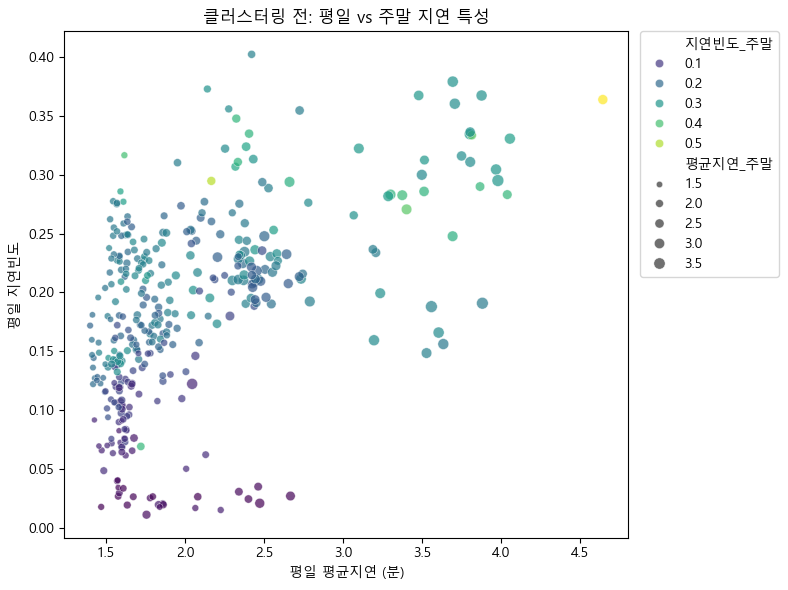

In [12]:
# ──────────────────────────────────────────────
# Cell 5: 클러스터링 전 Scatter Plot
# ──────────────────────────────────────────────
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=feat_pivot,
    x='평균지연_평일', y='지연빈도_평일',
    hue='지연빈도_주말',
    size='평균지연_주말',
    palette='viridis',
    alpha=0.7
)
plt.title('클러스터링 전: 평일 vs 주말 지연 특성')
plt.xlabel('평일 평균지연 (분)')
plt.ylabel('평일 지연빈도')
plt.legend(bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

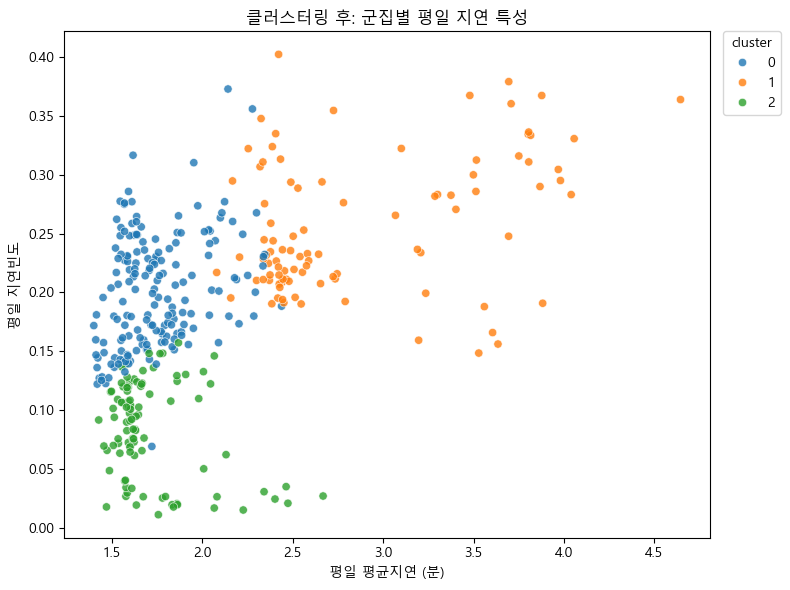

In [13]:
# ──────────────────────────────────────────────
# Cell 6: KMeans 클러스터링 + 후 Scatter Plot
# ──────────────────────────────────────────────
X = feat_pivot[['평균지연_평일', '지연빈도_평일', '평균지연_주말', '지연빈도_주말']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
feat_pivot['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=feat_pivot,
    x='평균지연_평일', y='지연빈도_평일',
    hue='cluster',
    palette='tab10',
    alpha=0.8
)
plt.title('클러스터링 후: 군집별 평일 지연 특성')
plt.xlabel('평일 평균지연 (분)')
plt.ylabel('평일 지연빈도')
plt.legend(title='cluster', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

In [14]:
# ──────────────────────────────────────────────
# Cell 7: 클러스터별 역 개수 확인
# ──────────────────────────────────────────────
print("클러스터별 역 개수:\n", feat_pivot['cluster'].value_counts())

클러스터별 역 개수:
 cluster
0    176
2    100
1     95
Name: count, dtype: int64


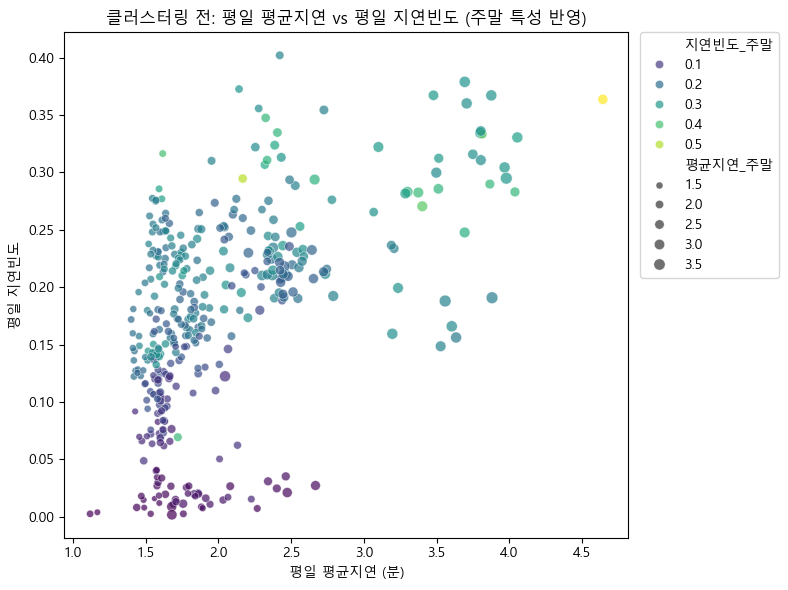

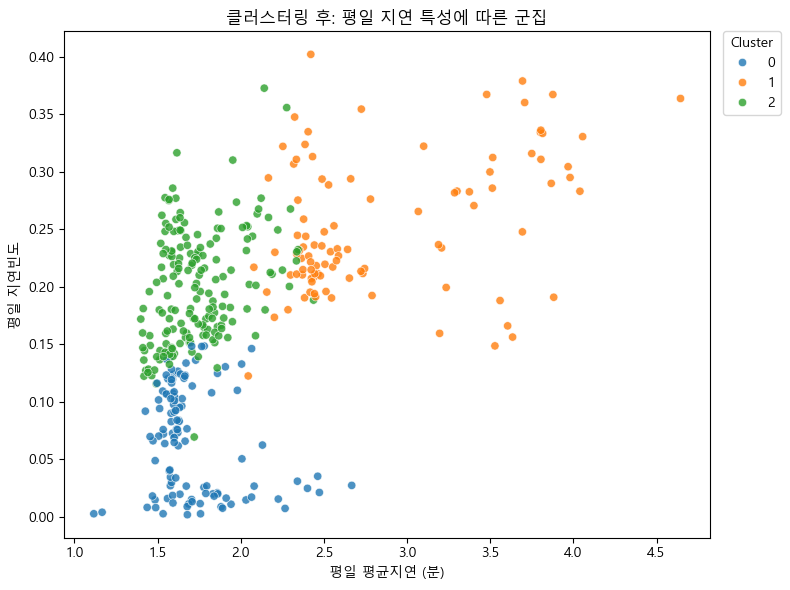

Cluster 0 sample stations: ['가락시장', '가양', '강남', '강동구청', '강변']
Cluster 1 sample stations: ['가능', '간석', '강일', '개봉', '경마공원']
Cluster 2 sample stations: ['가산디지털단지', '강남구청', '강동', '개롱', '개화산']


,평균지연_주말,평균지연_평일,지연빈도_주말,지연빈도_평일,cluster
역사명,,,,,
가능,3.036012,2.734343,0.265403,0.211538,1
가락시장,1.885249,1.729036,0.129851,0.136213,0
가산디지털단지,2.214303,2.098895,0.181001,0.263323,2
가양,2.333333,1.756250,0.026549,0.011478,0
간석,2.313978,2.318720,0.340659,0.306686,1


최종 남은 역 개수: 385개, 피처 수: 4개


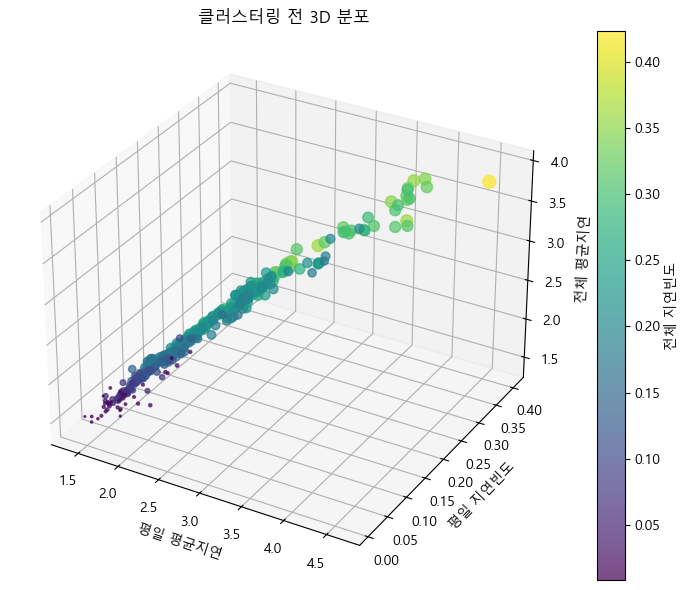

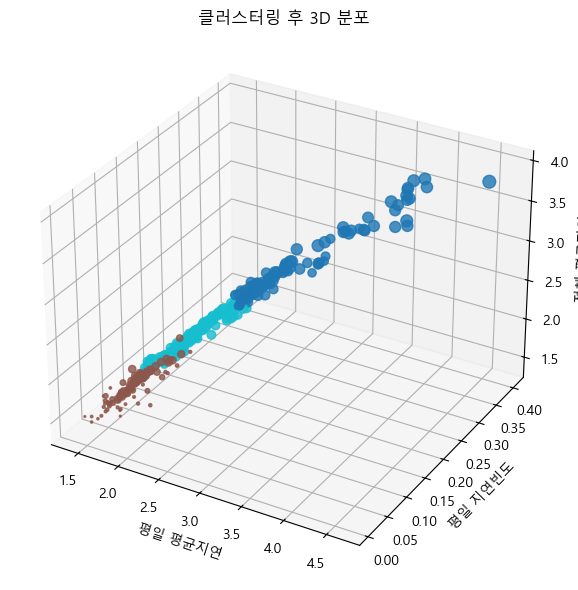

클러스터별 역 개수:
 cluster
2    174
1    116
0     95
Name: count, dtype: int64


In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 한글 폰트/마이너스 기호 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ──────────────────────────────────────────────
# Cell 1: all_df 불러오기 및 전처리
# ──────────────────────────────────────────────
base_dir      = 'data'
time_slots    = ['morning', 'afternoon', 'evening']
holiday_dates = {'0603', '0606'}
year          = 2025

records = []
for date in sorted(os.listdir(base_dir)):
    if not date.isdigit():
        continue
    for ts in time_slots:
        path = os.path.join(base_dir, date, f'delay_{date}_{ts}.csv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, parse_dates=['예정시간', '실제시간'])
        df['날짜'] = date
        df['시간대'] = ts

        dt = datetime.strptime(f'{year}{date}', '%Y%m%d')
        if date in holiday_dates:
            df['요일구분'] = '공휴일'
        elif dt.weekday() < 5:
            df['요일구분'] = '평일'
        else:
            df['요일구분'] = '주말'

        records.append(df)

all_df = pd.concat(records, ignore_index=True)

# ──────────────────────────────────────────────
# Cell 2: 9호선 제거 + 지연여부 플래그
# ──────────────────────────────────────────────
df = all_df[all_df['호선'] != '9호선'].copy()
df['지연여부'] = df['지연시간(분)'] >= 1

# ──────────────────────────────────────────────
# Cell 3: 지연건수 10회 이하 역 제거
# ──────────────────────────────────────────────
sub = df[df['요일구분'].isin(['평일', '주말'])].copy()
sub['지연시간_지연건'] = sub['지연시간(분)'].where(sub['지연여부'], pd.NA)
delay_counts = sub[sub['지연여부']].groupby('역사명').size()
valid = delay_counts[delay_counts > 10].index
sub = sub[sub['역사명'].isin(valid)]

# ──────────────────────────────────────────────
# Cell 4: 피처 생성 (평일 + 전체)
# ──────────────────────────────────────────────
weekday = sub[sub['요일구분']=='평일'].groupby('역사명').agg(
    평균지연_평일=('지연시간_지연건','mean'),
    지연빈도_평일=('지연여부','mean')
)
overall = sub.groupby('역사명').agg(
    평균지연_전체=('지연시간_지연건','mean'),
    지연빈도_전체=('지연여부','mean')
)
feat = weekday.join(overall, how='inner').dropna()
print(f"최종 남은 역 개수: {feat.shape[0]}개, 피처 수: {feat.shape[1]}개")

# ──────────────────────────────────────────────
# Cell 5: 클러스터링 전 3D Scatter Plot
# ──────────────────────────────────────────────
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    feat['평균지연_평일'], feat['지연빈도_평일'], feat['평균지연_전체'],
    c=feat['지연빈도_전체'], cmap='viridis', s=feat['지연빈도_전체']*200, alpha=0.7
)
ax.set_xlabel('평일 평균지연')
ax.set_ylabel('평일 지연빈도')
ax.set_zlabel('전체 평균지연')
fig.colorbar(p, label='전체 지연빈도')
plt.title('클러스터링 전 3D 분포')
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────
# Cell 6: KMeans 클러스터링 + 후 3D Scatter Plot
# ──────────────────────────────────────────────
X = feat[['평균지연_평일','지연빈도_평일','평균지연_전체','지연빈도_전체']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
feat['cluster'] = kmeans.fit_predict(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    feat['평균지연_평일'], feat['지연빈도_평일'], feat['평균지연_전체'],
    c=feat['cluster'], cmap='tab10', s=feat['지연빈도_전체']*200, alpha=0.8
)
ax.set_xlabel('평일 평균지연')
ax.set_ylabel('평일 지연빈도')
ax.set_zlabel('전체 평균지연')
legend1 = ax.legend(*sc.legend_elements(), title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.add_artist(legend1)
plt.title('클러스터링 후 3D 분포')
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────
# Cell 7: 클러스터별 역 개수 확인
# ──────────────────────────────────────────────
print("클러스터별 역 개수:\n", feat['cluster'].value_counts())